### Sentiment analysis using LSTM

In [ ]:
!pip install textblob
!pip install keras
!pip install nltk

In [ ]:
!pip install tensorflow

In [2]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [8]:
#Loading the dataset
data = pd.read_csv(r"/content/amazon_alexa.tsv",sep='\t')
# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [9]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [10]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [11]:
def cleaning(df, stop_words):

    #converting to lowercase
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:

            ' '.join(x.lower() for x in x.split()))


    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace('d', ''

            )

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:

            ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:

            ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)

<ipython-input-11-02a8ec9e6994>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
<ipython-input-11-02a8ec9e6994>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].str.replace('d', ''
<ipython-input-11-02a8ec9e6994>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [12]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


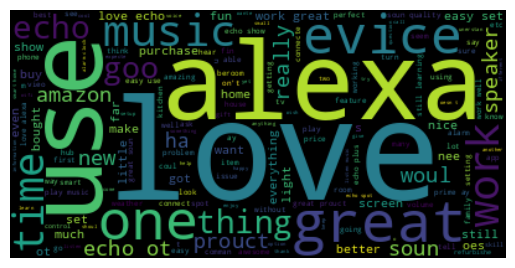

In [13]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
data_v1.head(10)

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive
5,receive echo gift. neee another bluetooth some...,Positive
6,"without cellphone, cannot use many features. i...",Negative
7,think 5th one i've purchase. i'm working getti...,Positive
8,look great,Positive
9,love it! i’ve listene song haven’t hear since ...,Positive


In [24]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0,   5],
       [  0,   0,   0, ..., 263, 276,  24],
       ...,
       [  0,   0,   0, ...,  89, 326,  32],
       [  0,   0,   0, ..., 217,  58, 290],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [31]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 319, 120)          60000     
                                                                 
 spatial_dropout1d_4 (Spati  (None, 319, 120)          0         
 alDropout1D)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 176)               209088    
                                                                 
 dense_4 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269442 (1.03 MB)
Trainable params: 269442 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
#Splitting the data into training and testing
# One-hot encoding the 'sentiment' column
y = pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [27]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [32]:
batch_size=32
# Training the model and storing the history
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
69/69 [==============================] - 98s 1s/step - loss: 0.4173 - accuracy: 0.8671 - val_loss: 0.3992 - val_accuracy: 0.8571
Epoch 2/5
69/69 [==============================] - 89s 1s/step - loss: 0.3252 - accuracy: 0.8803 - val_loss: 0.3202 - val_accuracy: 0.8646
Epoch 3/5
69/69 [==============================] - 88s 1s/step - loss: 0.2466 - accuracy: 0.9020 - val_loss: 0.2764 - val_accuracy: 0.8772
Epoch 4/5
69/69 [==============================] - 89s 1s/step - loss: 0.2176 - accuracy: 0.9156 - val_loss: 0.2676 - val_accuracy: 0.8804
Epoch 5/5
69/69 [==============================] - 93s 1s/step - loss: 0.1933 - accuracy: 0.9288 - val_loss: 0.2470 - val_accuracy: 0.8952


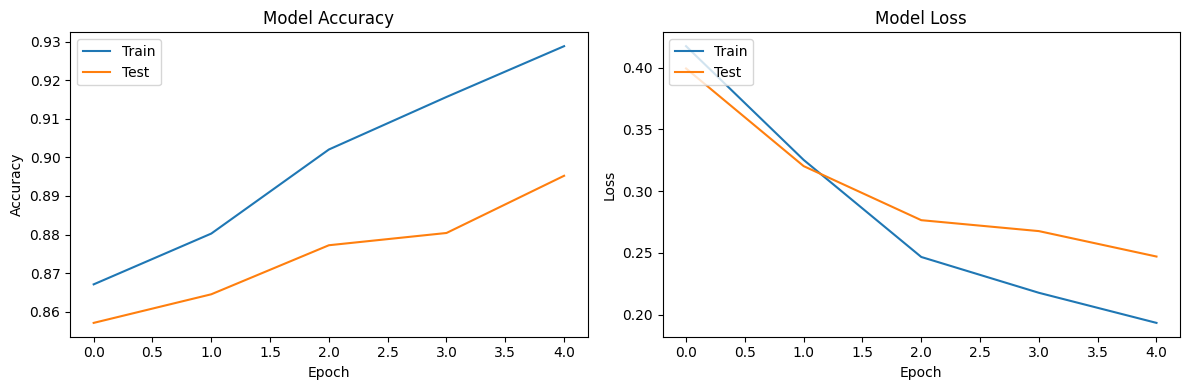

In [33]:
# Plotting accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

30/30 [==============================] - 5s 150ms/step - loss: 0.2470 - accuracy: 0.8952
Test Loss: 0.2470
Test Accuracy: 0.8952
